# Med Imagetools Tutorial 2: Segmentation with Med-Imagetools and torchio

In this tutorial, we will show how med-imagetools can make the data preparation task for any Machine learning task very easy, inspite of messy datasets. Additionally it takes advantage of the different relationships between different modalities and these relationships can be easily incorporated in a Machine Learning Pipeline. 

We will showcase the data preparation pipeline taking from raw dataset to torchloader. Here for the sake of brevity, we are going to use already processed data from Autopipeline. We will use the Dataset Class from med-imagetools which processes the processed dataset, loads the nrrds and converts the data into list of torchio subjects. A single subject can contain multiple modalities and multiple metadata, making it data rich. Then using torchio subject class , we load the subjects and form dataset which gets loaded into torchloader, ready for Machine Learning.  

For this tutorial, we will segment ***Body*** from the [HNSCC-3DCT-RT](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=39879146) dataset. Its a publicly available dataset consisting of 31 patients.

## Setup

In [1]:
%pip install --quiet med-imagetools
%pip install --quiet med-imagetools[debug]
%pip install -q pytorch-lightning==1.4.4
%pip install unet

     |████████████████████████████████| 57 kB 2.4 MB/s 
     |████████████████████████████████| 48.4 MB 19 kB/s 
     |████████████████████████████████| 2.0 MB 35.0 MB/s 
     |████████████████████████████████| 164 kB 47.1 MB/s 
     |████████████████████████████████| 918 kB 4.3 MB/s 
     |████████████████████████████████| 332 kB 46.8 MB/s 
     |████████████████████████████████| 132 kB 48.1 MB/s 
     |████████████████████████████████| 596 kB 40.0 MB/s 
     |████████████████████████████████| 829 kB 31.0 MB/s 
     |████████████████████████████████| 1.1 MB 35.1 MB/s 
     |████████████████████████████████| 192 kB 48.4 MB/s 
     |████████████████████████████████| 271 kB 49.4 MB/s 
     |████████████████████████████████| 160 kB 50.2 MB/s 


In [2]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchio as tio
import os
from torch.utils.data import DataLoader
from typing import List
import re
from unet import UNet
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torch.autograd import Variable
from matplotlib import pyplot as plt
from imgtools.io import Dataset
import shutil
import pathlib
import urllib.request as request
from zipfile import ZipFile
%load_ext tensorboard

## Download the dataset

The dataset for the sake of brevity has already been prepared using autopipeline.py and compressed as zip. We load the processed dataset from [github link](https://github.com/skim2257/tcia_samples)

```
python ./imgtools/autopipeline.py\ 
"/cluster/home/ramanav/data/TCIA HNSCC-3DCT-RT"\
/cluster/projects/radiomics/Temp/vishwesh/demo_data\
--modalities RTDOSE,CT,RTSTRUCT\
--spacing 4 4 0\
--n_jobs 8\
--visualize True
```

In [5]:
print("Downloading the test dataset...")
curr_path = pathlib.Path().parent.parent.resolve()
quebec_path = pathlib.Path(os.path.join(curr_path,"data"))

if not os.path.exists(quebec_path):
  pathlib.Path(quebec_path).mkdir(parents=True, exist_ok=True)
  quebec_data_url = "https://github.com/bhklab/tcia_samples/blob/main/HNSCC-3DCT-RT.zip?raw=true"
  quebec_zip_path = os.path.join(quebec_path, "HNSCC-3DCT-RT.zip")
  request.urlretrieve(quebec_data_url, quebec_zip_path) 
  with ZipFile(quebec_zip_path, 'r') as zipfile:
      zipfile.extractall(quebec_path)
  os.remove(quebec_zip_path)
else:
  print("Data already present")

## Load the dataset

Here, before we load our dataset, we define an extra torchio transform, useful for selecting labels corresponding to the ROI names that the user wants

In [7]:
class select_roi_names(tio.LabelTransform):
    """
    Based on the given roi names, selects from the given set
    """
    def __init__(
            self,
            roi_names: List[str] = None,
            **kwargs
            ) -> None:
        super().__init__(**kwargs)
        self.kwargs = kwargs
        self.roi_names = roi_names
    
    def apply_transform(self,subject):
        #list of roi_names
        for image in self.get_images(subject):
            #For only applying to labelmaps
            metadata = subject["metadata_RTSTRUCT_CT"]
            patterns = self.roi_names
            mask = torch.empty_like(image.data)[:len(patterns)]
            for j,pat in enumerate(patterns):
                k = []
                for i,col in enumerate(metadata):
                    if re.match(pat,col,flags=re.IGNORECASE):
                        k.append(i)
                if len(k)==0:
                    mask[j] = mask[j]*0
                else:  
                    mask[j] = (image.data[k].sum(axis=0)>0)*1    
            image.set_data(mask)
        return subject
    
    def is_invertible(self):
        return False

We define here there directory name and required torchio transforms. We also specify the label map that we are interested in

In [9]:
#Data directory
output_directory = os.path.join(curr_path,"data","demo_data_v2")

#Defining Transforms
train_transforms = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((96,96,40)),
    select_roi_names(["Body"]),
    tio.ZNormalization(),
    tio.RandomFlip(),
    tio.OneHot()])

val_transforms = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((96,96,40)),
    select_roi_names(["Body"]),
    tio.ZNormalization(),
    tio.OneHot()])

Med-imagetools uses dataset class to load all the nrrd files into list of torchio subject instances

In [10]:
#Loading all the files and transforming all the components into List of tio.subjects
subjects = Dataset.load_from_nrrd(output_directory,ignore_multi=True)

100%|██████████| 43/43 [00:00<00:00, 1588.78it/s]


We now convert the list of torchio subjects to torchio subject dataset and eventually load it using torch dataloader

In [11]:
#Splitting into test and train
training_split_ratio = 0.8
num_subjects = len(subjects)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects
num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

#Defining training and validation dataset
training_set = tio.SubjectsDataset(
    training_subjects, transform=train_transforms) 

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=val_transforms)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

training_batch_size = 4
validation_batch_size = 1

# Torch Data loader
training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn = lambda x: (torch.stack(tuple(items["mod_CT"].data for items in x)),
                            torch.stack(tuple(items["mod_RTSTRUCT_CT"].data for items in x)))
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=4,
    collate_fn = lambda x: (torch.stack(tuple(items["mod_CT"].data for items in x)),
                            torch.stack(tuple(items["mod_RTSTRUCT_CT"].data for items in x)))
)

Training set: 34 subjects
Validation set: 9 subjects


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Dataset Visualization

In [12]:
training_instance = training_set[24]
print(training_instance)
print(training_instance["mod_CT"].data.shape)
print(training_instance["mod_RTSTRUCT_CT"].data.shape)
print(training_instance["metadata_RTSTRUCT_CT"])
print(training_instance["metadata_RTDOSE_CT"])

Subject(Keys: ('mod_CT', 'mod_RTSTRUCT_CT', 'metadata_RTSTRUCT_CT', 'mod_RTDOSE_CT', 'metadata_RTDOSE_CT'); images: 3)
torch.Size([1, 96, 96, 40])
torch.Size([2, 96, 96, 40])
['BODY', 'Spinal Cord', 'BRAIN STEM', 'OPTIC N R', 'COCHLEA L', 'PAROTID L', 'CHIASM', 'COCHLEA R', 'PAROTID R', 'ORAL CAVITY', 'MANDIBLE', 'OPTIC N L', 'LIPS', 'Esophagus', 'GTV 1 NODE', 'GTV 1', 'CTV 1', 'PTV 1', 'CTV 1 NODE', 'PTV 1 NODE', 'CTV 2 IB LEFT', 'CTV 2 I-V L', 'PTV 2 I-V L', 'PTV 2 IB L', 'CTV 3 IV L', 'PTV 3 IV L', 'CTV 3 RETRO L', 'PTV 3 RETRO L', 'CTV 3 II-IV R', 'PTV 3 II-IV R', 'CTV 3 RETRO R', 'PTV 3 RETRO R', 'GSL', 'OARpharynx', 'PRV spinal cord', 'CouchSurface', 'CouchInterior', 'CouchRailLeft', 'CouchRailRight', 'OptPTV2I_VL5940', 'OptPTV2IB_L5940', 'OptPTV3IV_L5445', 'OptPTV3retL_5445', 'OptPTV3retR_5445', 'PRVBrainstem', 'Dose 7600[cGy]', 'Dose 7500[cGy]', 'Dose 5930[cGy]', 'CTV HR', 'CTV LR']
{}


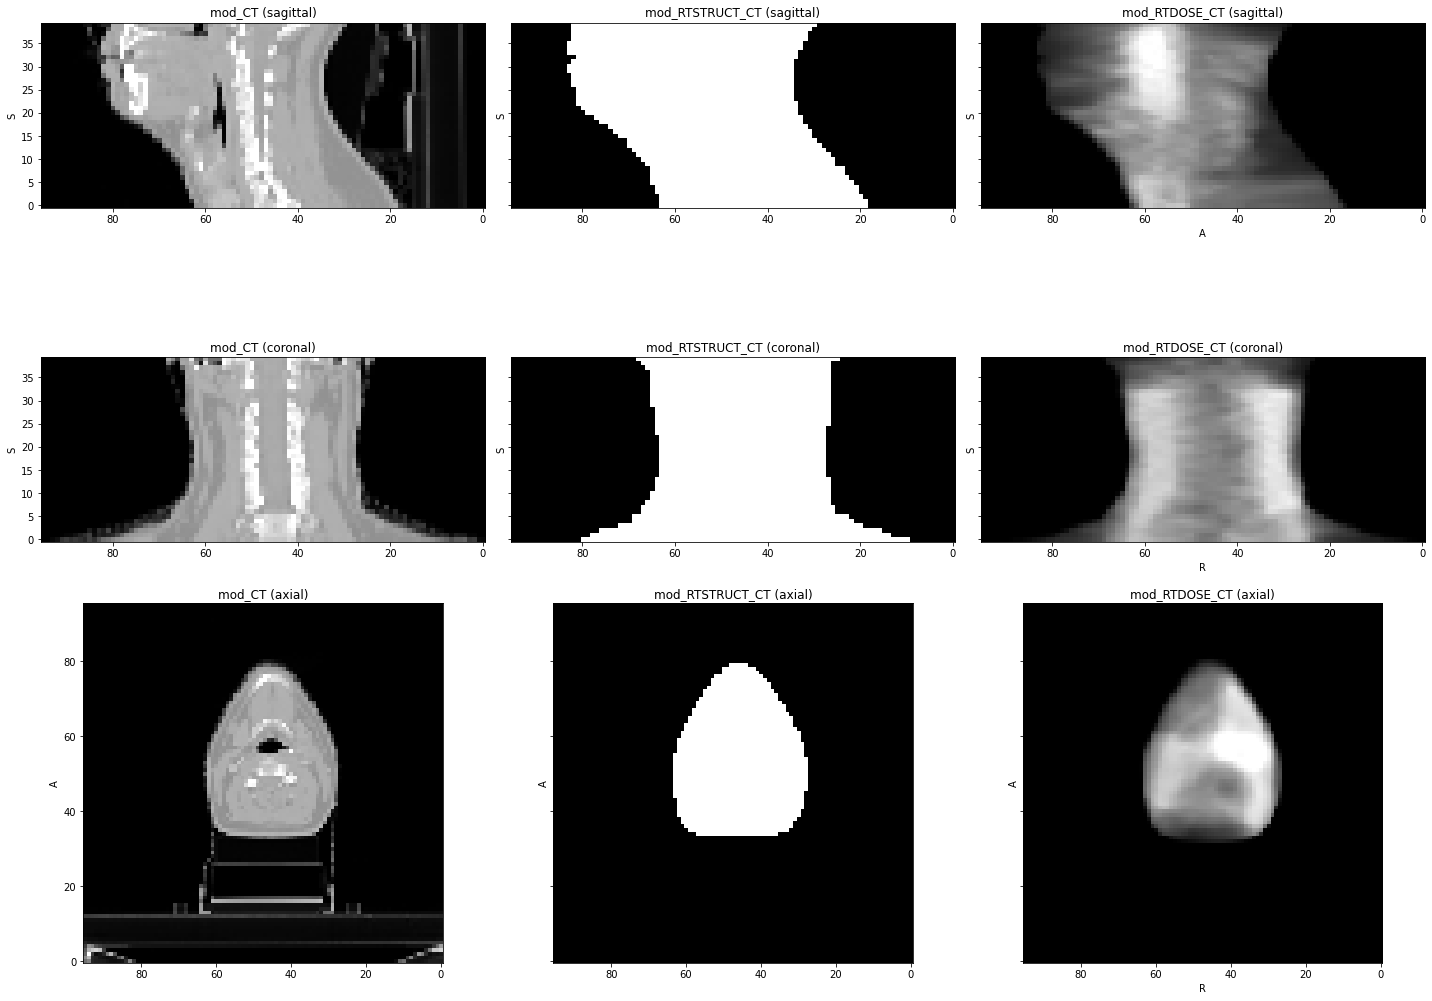

In [13]:
training_instance.plot(figsize=[20,15])

## Setting Machine Learning Pipeline: Segmenation using UNET

We define the training pipeline and loss function using pytorch lightning

In [14]:
class SegmentationPipeline(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate,weight_decay, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        return optimizer
    
    def infer_batch(self, batch):
        x, y = batch
        output = self.net(x)
        y_hat = F.softmax(output, dim=1)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y).mean()
        dice_score = 1-loss
        self.log('train_loss', loss, prog_bar=True)
        self.log('train dice score',dice_score)
        return loss
    
    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y).mean()
        dice_score = 1-loss
        self.log('val_loss', loss,prog_bar=True)
        self.log('val dice score',dice_score)
        return loss

#DICE Loss function taken from torchio tutorial
def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=[2,3,4])
    fp = (p0 * g1).sum(dim=[2,3,4])
    fn = (p1 * g0).sum(dim=[2,3,4])
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

We define the model, optimizer and create an instance of segmentation pipeline

In [18]:
#Defning Models
model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=2,
        out_channels_first_layer=16,
        normalization='batch',
        padding=True,
        activation='ReLU',
    )

pipeline = SegmentationPipeline(net=model,
                                learning_rate = 0.0001,
                                weight_decay = 0.0005,
                                criterion = get_dice_score,
                                optimizer_class = torch.optim.AdamW
                                )

early_stopping = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss')
trainer = pl.Trainer(gpus=1,
                     precision=16,
                     callbacks=[early_stopping],
                     max_epochs=20
                     )
trainer.logger._default_hp_metric = False

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Training of the model

In [ ]:
print("Starting training...")
trainer.fit(pipeline,training_loader,validation_loader)
print("Done...")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


Missing logger folder: /content/lightning_logs

  | Name | Type | Params
------------------------------
0 | net  | UNet | 241 K 
------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.964     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:32

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Visualization of the results

In [ ]:
%tensorboard --logdir lightning_logs

In [ ]:
def plot_segmentations(net, images, labels):
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
    #Pick random slice
    n = np.random.randint(np.shape(images)[-1])
    output = net(images)
    output = F.softmax(output, dim=1)
    pixels = torch.argmax(output[0], axis=0).float()/2
    labels_map = torch.argmax(labels[0], axis=0)
    fig = plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title("CT image")
    plt.imshow(images[0,0,:,:,n].detach().cpu())
    plt.subplot(1,3,2)
    plt.title("Segmentation Map")
    plt.imshow(pixels[:,:,n].detach().cpu())
    plt.subplot(1,3,3)
    plt.title("RT Struct Label Map")
    plt.imshow(labels_map[:,:,n].detach().cpu())
    return fig

In [ ]:
inputs,labels = next(iter(validation_loader))
model = model.cuda()
fig = plot_segmentations(model, inputs, labels)
plt.show()